In [15]:
import os
import sys

sys.path.append(os.path.abspath(os.path.dirname(os.path.dirname(os.path.join(os.getcwd())))))

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from data_utils.utils import keep_existing_photos, downsample_group
from data_utils.dataset import (
    PhotoLabelDataset,
    stratified_split_dataset,
    train_transform,
    val_transform,
)
from model.resnet18 import Resnet18FineTuneModel
from model.utils import (
    get_device,
    train_model_single_epoch,
    validate_model_single_epoch,
    save_checkpoint,
    evaluate_on_test,
    plot_history,
)

### Data preprocessing

In [3]:
base_dir = "../../"

business_df = pd.read_json(f'{base_dir}data/yelp_dataset/yelp_academic_dataset_business.json', lines=True)
photos_df = pd.read_json(f'{base_dir}data/yelp_photos/photos.json', lines=True)

photo_dir = f"{base_dir}data/yelp_photos/resized_photos"
photos_df = keep_existing_photos(photos_df, photo_dir)

photos_df = photos_df[photos_df['label'] == 'food'].copy()

categories_df = business_df[['business_id', 'attributes']].copy()
photos_df = photos_df.merge(categories_df, on="business_id", how="left")

photos_df = photos_df[photos_df['attributes'].notna()]
photos_df['price_range'] = photos_df['attributes'].apply(lambda x: x.get('RestaurantsPriceRange2'))

photos_df['price_range'] = photos_df['price_range'].astype(int)
photos_df['price_range'] = photos_df['price_range'].replace(4, 3)

Checking images: 100%|██████████| 200100/200100 [00:05<00:00, 35126.70it/s]


In [4]:
photos_df.price_range.value_counts()

price_range
2    63103
1    25719
3     8107
Name: count, dtype: int64

In [5]:
price_3_num = (photos_df.price_range == 3).sum()

food_df = photos_df.groupby('price_range', group_keys=False).apply(
    lambda x: downsample_group(x, price_3_num) if x.name in [1, 2] else x  # Only downsample for price_range 1 and 2
)

food_df['price_range'] = food_df['price_range'] - 1

/var/folders/6n/sm2tfzkn2hjd8cpfn_256ph00000gp/T/ipykernel_74003/878610299.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  food_df = photos_df.groupby('price_range', group_keys=False).apply(


In [9]:
label = 'price_range'

price_dataset = PhotoLabelDataset(food_df, photo_dir, label)
labels = food_df[label].values 
train_size = 0.85
val_size = 0.10

train_dataset, val_dataset, test_dataset = stratified_split_dataset(
    price_dataset,
    labels,
    train_size=train_size,
    val_size=val_size,
    random_state=42
)

train_dataset.transform = train_transform
val_dataset.transform = val_transform
test_dataset.transform = val_transform

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

for images, labels in train_loader:
    print("Images shape:", images.shape)  
    print("Labels shape:", labels.shape)
    break

Images shape: torch.Size([64, 3, 224, 224])
Labels shape: torch.Size([64])


### Model training

In [10]:
num_classes = 3
device = get_device()

model = Resnet18FineTuneModel(num_classes=3)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
scaler = torch.amp.GradScaler("cuda")
grad_clip = 1
ckpt_dir = "checkpoints/price_models"

history = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, device, scaler, grad_clip, history, ckpt_dir, num_epochs=10):
    model.train()

    for epoch in range(1, num_epochs+1):
        train_loss, train_accuracy = train_model_single_epoch(
            model, train_loader, criterion, optimizer, device, scaler, grad_clip
        )
        val_loss, val_accuracy = validate_model_single_epoch(model, val_loader, criterion, device)

        print(
            f"[Epoch {epoch}/{num_epochs}]",
            f"Train Loss: {train_loss:.4f} | " f"Train Accuracy: {train_accuracy:.4f}",
            f"Val Loss: {val_loss:.4f} | " f"Val Accuracy: {val_accuracy:.4f}"
        )

        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        save_checkpoint(epoch, model, optimizer, history, ckpt_dir)

/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  

In [8]:
num_epochs = 10
train_model(model, train_loader, val_loader, criterion, optimizer, device, scaler, grad_clip, history, ckpt_dir, num_epochs=num_epochs)

Training: 100%|██████████| 323/323 [00:56<00:00,  5.73it/s, loss=0.769]


[Epoch 1/10] Train Loss: 0.8741 | Train Accuracy: 0.5837 Val Loss: 0.8356 | Val Accuracy: 0.5987
Model checkpoint saved at checkpoints/price_models/ckpt_1


Training: 100%|██████████| 323/323 [00:53<00:00,  6.04it/s, loss=0.746]


[Epoch 2/10] Train Loss: 0.7275 | Train Accuracy: 0.6613 Val Loss: 0.7992 | Val Accuracy: 0.6291
Model checkpoint saved at checkpoints/price_models/ckpt_2


Training: 100%|██████████| 323/323 [00:52<00:00,  6.13it/s, loss=0.68] 


[Epoch 3/10] Train Loss: 0.6044 | Train Accuracy: 0.7312 Val Loss: 0.8198 | Val Accuracy: 0.6184
Model checkpoint saved at checkpoints/price_models/ckpt_3


Training: 100%|██████████| 323/323 [00:52<00:00,  6.11it/s, loss=0.582]


[Epoch 4/10] Train Loss: 0.4342 | Train Accuracy: 0.8216 Val Loss: 1.2097 | Val Accuracy: 0.5983
Model checkpoint saved at checkpoints/price_models/ckpt_4


Training: 100%|██████████| 323/323 [00:51<00:00,  6.22it/s, loss=0.241] 


[Epoch 5/10] Train Loss: 0.2674 | Train Accuracy: 0.8991 Val Loss: 1.3424 | Val Accuracy: 0.6386
Model checkpoint saved at checkpoints/price_models/ckpt_5


Training: 100%|██████████| 323/323 [00:48<00:00,  6.66it/s, loss=0.232] 


[Epoch 6/10] Train Loss: 0.1804 | Train Accuracy: 0.9344 Val Loss: 1.4520 | Val Accuracy: 0.6324
Model checkpoint saved at checkpoints/price_models/ckpt_6


Training: 100%|██████████| 323/323 [00:48<00:00,  6.65it/s, loss=0.0446]


[Epoch 7/10] Train Loss: 0.1400 | Train Accuracy: 0.9488 Val Loss: 1.4139 | Val Accuracy: 0.6328
Model checkpoint saved at checkpoints/price_models/ckpt_7


Training: 100%|██████████| 323/323 [00:51<00:00,  6.22it/s, loss=0.0523]


[Epoch 8/10] Train Loss: 0.1073 | Train Accuracy: 0.9612 Val Loss: 1.7732 | Val Accuracy: 0.6361
Model checkpoint saved at checkpoints/price_models/ckpt_8


Training: 100%|██████████| 323/323 [00:53<00:00,  6.06it/s, loss=0.119] 


[Epoch 9/10] Train Loss: 0.0978 | Train Accuracy: 0.9621 Val Loss: 1.7108 | Val Accuracy: 0.6406
Model checkpoint saved at checkpoints/price_models/ckpt_9


Training: 100%|██████████| 323/323 [00:54<00:00,  5.94it/s, loss=0.104]  


[Epoch 10/10] Train Loss: 0.0854 | Train Accuracy: 0.9682 Val Loss: 2.0270 | Val Accuracy: 0.6155
Model checkpoint saved at checkpoints/price_models/ckpt_10


In [11]:
ckpt = torch.load(f"{base_dir}saved_models/price_multiclass/ckpt_best")
model = Resnet18FineTuneModel(num_classes=num_classes)
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)
model.eval()

Resnet18FineTuneModel(
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [18]:
torch.save({'model_state_dict': ckpt['model_state_dict']}, 'best_model.pth')

In [12]:
model.eval()
evaluate_on_test(model, test_loader, device, ['0', '1', '2'])

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.78      0.59      0.67       406
           1       0.50      0.57      0.53       405
           2       0.66      0.72      0.69       406

    accuracy                           0.63      1217
   macro avg       0.65      0.63      0.63      1217
weighted avg       0.65      0.63      0.63      1217



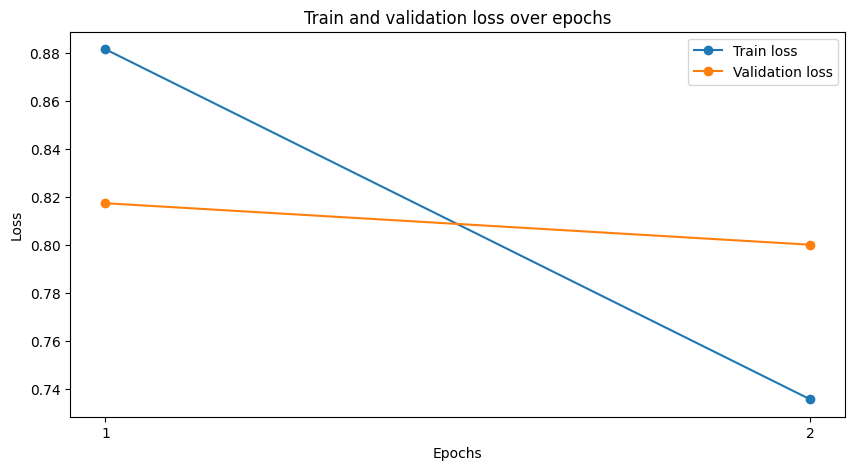

In [13]:
history = ckpt['history']
plot_history(history, 'loss')

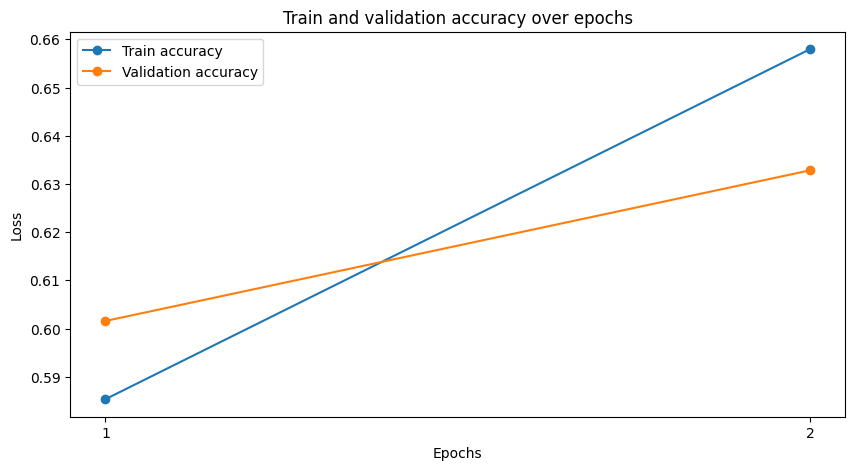

In [14]:
plot_history(history, 'accuracy')